In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os.path as osp
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread

### 시각화를 위한 함수 정의 (지난 강의와 동일)

In [3]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

### 데이터셋 불러오기 (지난 강의와 동일)

In [5]:
DATASET_DIR = '/opt/ml/input/data/ICDAR17_Korean_Eng'  # FIXME

ufo_fpath = osp.join(DATASET_DIR, 'ufo/train.json')
with open(ufo_fpath, 'r') as f:
    ufo_anno = json.load(f)

sample_ids = sorted(ufo_anno['images'])

In [6]:
SAMPLE_IDX = 7

sample_id = sample_ids[SAMPLE_IDX]
image_fpath = osp.join(DATASET_DIR, 'images', sample_id)
image = imread(image_fpath)

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in ufo_anno['images'][sample_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)

print('Bboxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

Image:	(1936, 2592, 3)
Bboxes:	(1, 4, 2)
Labels:	(1,)


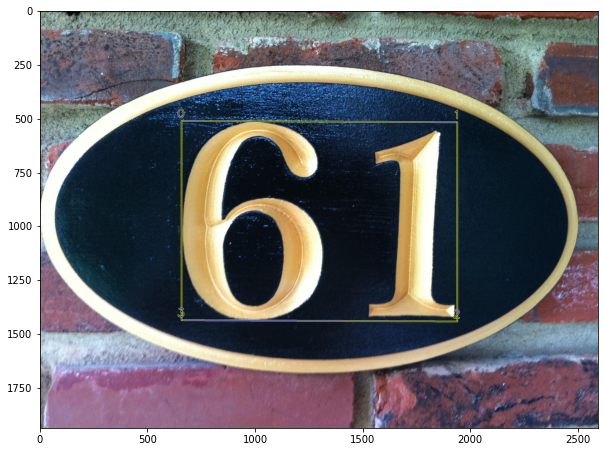

In [7]:
vis = image.copy()
draw_bboxes(vis, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)

plt.figure(figsize=(10, 10))
plt.imshow(vis)

# Pre-processing & Data Augmentation을 위한 함수 작성

### Albumentations 이용해보기

Pre-processing 및 Data Augmentation을 위해 가장 기본적으로 이용하는 `torchvision.transforms`와 유사한 방식으로 이용할 수 있는 라이브러리

`torchvision.transforms`에 비해 1) 실행 속도가 더 빠르고, 2) 더 다양한 기능을 제공한다.

In [8]:
import albumentations as A

In [9]:
FIG_SIZE = (5, 5)

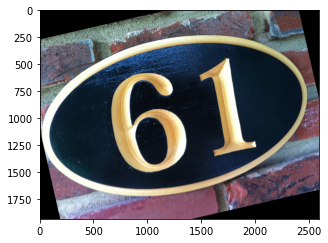

In [10]:
func_list = [
    A.Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
]
alb_transform = A.Compose(func_list)

transformed = alb_transform(image=image)

plt.figure(figsize=FIG_SIZE)
plt.imshow(transformed['image'])

### 더 다양한 Augmentation을 적용해보자

1. Scale
2. Rotate
3. Horizontal / Vertical Flip

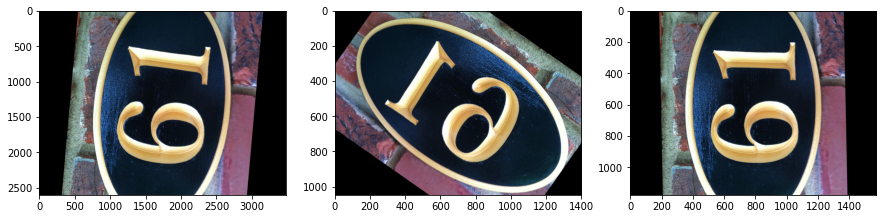

In [11]:
alb_transform = A.Compose([
    A.RandomScale(p=1.0, scale_limit=0.5),
    A.Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(), A.VerticalFlip()
])

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1]))
axs[0].imshow(alb_transform(image=image)['image'])
axs[1].imshow(alb_transform(image=image)['image'])
axs[2].imshow(alb_transform(image=image)['image'])

### Batch Processing을 위해 일정한 크기로 조절

1. Rotate
2. Horizontal / Vertical Flip
3. Crop & Resize

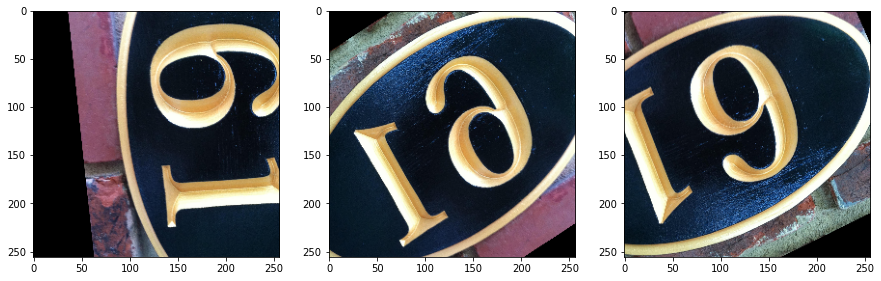

In [12]:
alb_transform = A.Compose([
    A.Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(), A.VerticalFlip(),
    A.RandomResizedCrop(p=1.0, height=256, width=256, scale=(0.5, 1.0), ratio=(3 / 4, 4 / 3))
])

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1]))
axs[0].imshow(alb_transform(image=image)['image'])
axs[1].imshow(alb_transform(image=image)['image'])
axs[2].imshow(alb_transform(image=image)['image'])

### 주의 사항 1: 이미지 영역 손실

함수를 적용하는 순서 등에 따라 이미지 영역의 손실이 발생할 수 있는데, 한 번 손실된 영역은 다시 복구되지 않기 때문에 함수 적용 순서에 주의해야 한다.

Text(0.5, 1.0, 'Rotate & Crop')

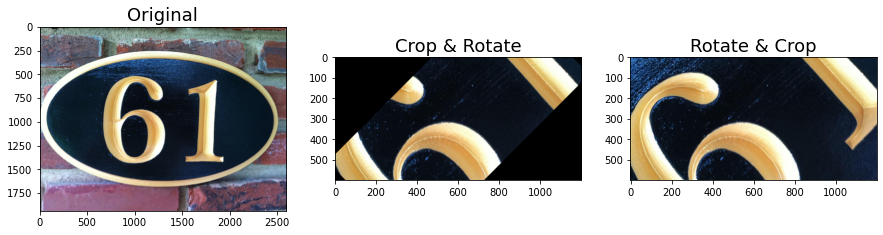

In [13]:
transform_1 = A.Compose([
    A.CenterCrop(height=600, width=1200),
    A.Rotate(p=1.0, limit=(45, 45), border_mode=cv2.BORDER_CONSTANT),
])

transform_2 = A.Compose([
    A.Rotate(p=1.0, limit=(45, 45), border_mode=cv2.BORDER_CONSTANT),
    A.CenterCrop(height=600, width=1200),
])

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1]))
axs[0].imshow(image)
axs[0].set_title('Original', fontsize=18)
axs[1].imshow(transform_1(image=image)['image'])
axs[1].set_title('Crop & Rotate', fontsize=18)
axs[2].imshow(transform_2(image=image)['image'])
axs[2].set_title('Rotate & Crop', fontsize=18)

### 주의 사항 2: 해상도 손실

Augmentation 함수들의 계산량을 줄이기 위해 불러온 이미지를 일정 크기로 조절하는 경우 발생할 수 있다.

글자의 크기가 이미지 전체에 비해 작은 경우 특히 주의해야 한다.

Text(0.5, 1.0, 'Crop at Original Size')

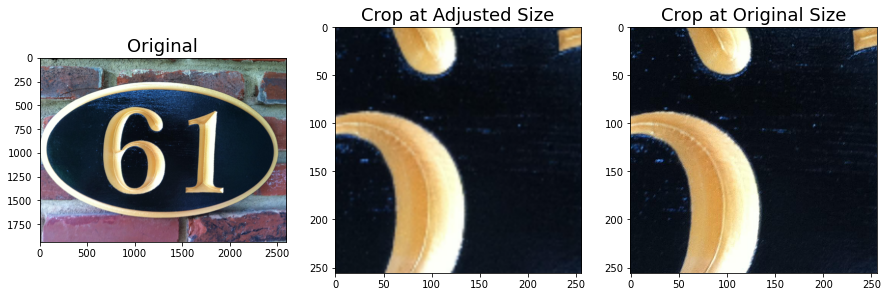

In [14]:
transform_1 = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.CenterCrop(p=1.0, height=128, width=128),
    A.Resize(height=256, width=256),
])

crop_size = int(max(image.shape[:2]) * 128 / 512)
transform_2 = A.Compose([
    A.CenterCrop(p=1.0, height=crop_size, width=crop_size),
    A.Resize(height=256, width=256),
])

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1]))
axs[0].imshow(image)
axs[0].set_title('Original', fontsize=18)
axs[1].imshow(transform_1(image=image)['image'])
axs[1].set_title('Crop at Adjusted Size', fontsize=18)
axs[2].imshow(transform_2(image=image)['image'])
axs[2].set_title('Crop at Original Size', fontsize=18)

### Bounding Box와 함께 변형하기

Scene Text Data를 다룰 때에는 Bounding Box에도 동일한 변형을 적용해서 이미지와의 위치가 틀어지지 않도록 해야 한다.

Albumentations에서는 제한된 형식의 Bounding Box에 대해서 해당 기능을 제공하고 있다.
- pascal_voc mode: (x_min, y_min, x_max, y_max)
- coco mode: (x_min, y_min, width, height)

더 자세한 이용법은 Albumentation의 [Bounding boxes augmentation for object detection" 문서](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation)를 참조

Text(0.5, 1.0, 'Transformed')

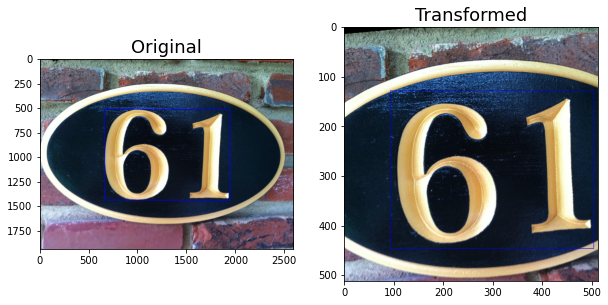

In [15]:
alb_transform = A.Compose([
    A.Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(), A.VerticalFlip(),
    A.RandomResizedCrop(p=1.0, height=512, width=512, scale=(0.5, 1.0), ratio=(3 / 4, 4 / 3))
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

bboxes_voc = []
for bbox in bboxes:
    x0, y0 = bbox.min(axis=0).astype(np.int64)
    x1, y1 = bbox.max(axis=0).astype(np.int64)
    bboxes_voc.append([x0, y0, x1, y1])

transformed = alb_transform(image=image, bboxes=bboxes_voc)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
vis = image.copy()
draw_bboxes(vis, bboxes, thickness=5)
axs[0].imshow(vis)
axs[0].set_title('Original', fontsize=18)
vis = transformed['image']
bboxes_transformed = np.array([
    [[x0, y0], [x1, y0], [x1, y1], [x0, y1]] for x0, y0, x1, y1 in transformed['bboxes']
], dtype=np.float32)
draw_bboxes(vis, bboxes_transformed)
axs[1].imshow(vis)
axs[1].set_title('Transformed', fontsize=18)

### 직접 구현해보기

상황에 따라 속도 혹은 (주로) 자유도의 문제로 Augmentation 함수를 직접 구현해서 이용하게 되는 경우가 있다.

예시로 제공되는 함수의 특징 및 개선점은 다음과 같다.

1. 여러 종류의 변환 함수를 하나의 함수로 통합함.
2. 다양한 형식의 Bounding Box 또는 Mask를 이용할 수 있음.
3. Patch Sampling에 다양한 규칙을 추가할 수 있음. (10강 - Bag of Tricks의 내용 참조)

모든 함수를 직접 구현하는 것은 비효율적이기 때문에 Albumentations에서 제공하는 함수들을과도 함께 이용할 수 있도록 작성하는 것이 좋다.

In [16]:
import numpy.random as npr
from albumentations.pytorch import ToTensorV2
from shapely.geometry import Polygon


def transform_by_matrix(matrix, image=None, oh=None, ow=None, word_bboxes=[],
                        by_word_char_bboxes=[], masks=[], inverse=False):
    """
    Args:
        matrix (ndarray): (3, 3) shaped transformation matrix.
        image (ndarray): (H, W, C) shaped ndarray.
        oh (int): Output height.
        ow (int): Output width.
        word_bboxes (List[ndarray]): List of (N, 2) shaped ndarrays.
        by_word_char_bboxes (List[ndarray]): Lists of (N, 4, 2) shaped ndarrays.
        masks (List[ndarray]): List of (H, W) shaped ndarray the same size as the image.
        inverse (bool): Whether to apply inverse transformation.
    """
    if image is not None or masks is not None:
        assert oh is not None and ow is not None

    output_dict = dict()

    if inverse:
        matrix = np.linalg.pinv(matrix)

    if image is not None:
        output_dict['image'] = cv2.warpPerspective(image, matrix, dsize=(ow, oh))

    if word_bboxes is None:
        output_dict['word_bboxes'] = None
    elif len(word_bboxes) > 0:
        num_points = list(map(len, word_bboxes))
        points = np.concatenate([np.reshape(bbox, (-1, 2)) for bbox in word_bboxes])  # (N, 2)
        points = cv2.perspectiveTransform(
            np.reshape(points, (1, -1, 2)).astype(np.float32), matrix).reshape(-1, 2)  # (N, 2)
        output_dict['word_bboxes'] = [
            points[i:i + n] for i, n in zip(np.cumsum([0] + num_points)[:-1], num_points)]
    else:
        output_dict['word_bboxes'] = []

    if by_word_char_bboxes is None:
        output_dict['by_word_char_bboxes'] = None
    elif len(by_word_char_bboxes) > 0:
        word_lens = list(map(len, by_word_char_bboxes))
        points = np.concatenate([np.reshape(bboxes, (-1, 2)) for bboxes in by_word_char_bboxes])  # (N, 2)
        points = cv2.perspectiveTransform(
            np.reshape(points, (1, -1, 2)).astype(np.float32), matrix).reshape(-1, 4, 2)  # (N, 4, 2)
        output_dict['by_word_char_bboxes'] = [
            points[i:i + n] for i, n in zip(np.cumsum([0] + word_lens)[:-1], word_lens)]
    else:
        output_dict['by_word_char_bboxes'] = []

    if masks is None:
        output_dict['masks'] = None
    else:
        output_dict['masks'] = [cv2.warpPerspective(mask, matrix, dsize=(ow, oh)) for mask in masks]

    return output_dict


class GeoTransformation:
    """
    Args:
    """
    def __init__(
        self,
        rotate_anchors=None, rotate_range=None,
        crop_aspect_ratio=None, crop_size=1.0, crop_size_by='longest', hflip=False, vflip=False,
        random_translate=False, min_image_overlap=0, min_bbox_overlap=0, min_bbox_count=0,
        allow_partial_occurrence=True,
        resize_to=None, keep_aspect_ratio=False, resize_based_on='longest', max_random_trials=100
    ):
        if rotate_anchors is None:
            self.rotate_anchors = None
        elif type(rotate_anchors) in [int, float]:
            self.rotate_anchors = [rotate_anchors]
        else:
            self.rotate_anchors = list(rotate_anchors)

        if rotate_range is None:
            self.rotate_range = None
        elif type(rotate_range) in [int, float]:
            assert rotate_range >= 0
            self.rotate_range = (-rotate_range, rotate_range)
        elif len(rotate_range) == 2:
            assert rotate_range[0] <= rotate_range[1]
            self.rotate_range = tuple(rotate_range)
        else:
            raise TypeError

        if crop_aspect_ratio is None:
            self.crop_aspect_ratio = None
        elif type(crop_aspect_ratio) in [int, float]:
            self.crop_aspect_ratio = float(crop_aspect_ratio)
        elif len(crop_aspect_ratio) == 2:
            self.crop_aspect_ratio = tuple(crop_aspect_ratio)
        else:
            raise TypeError

        if type(crop_size) in [int, float]:
            self.crop_size = crop_size
        elif len(crop_size) == 2:
            assert type(crop_size[0]) == type(crop_size[1])
            self.crop_size = tuple(crop_size)
        else:
            raise TypeError

        assert crop_size_by in ['width', 'height', 'longest']
        self.crop_size_by = crop_size_by

        self.hflip, self.vflip = hflip, vflip

        self.random_translate = random_translate

        self.min_image_overlap = max(min_image_overlap or 0, 0)
        self.min_bbox_overlap = max(min_bbox_overlap or 0, 0)
        self.min_bbox_count = max(min_bbox_count or 0, 0)
        self.allow_partial_occurrence = allow_partial_occurrence

        self.max_random_trials = max_random_trials

        if resize_to is None:
            self.resize_to = resize_to
        elif type(resize_to) in [int, float]:
            if not keep_aspect_ratio:
                self.resize_to = (resize_to, resize_to)
            else:
                self.resize_to = resize_to
        elif len(resize_to) == 2:
            assert not keep_aspect_ratio
            assert type(resize_to[0]) == type(resize_to[1])
            self.resize_to = tuple(resize_to)
        assert resize_based_on in ['width', 'height', 'longest']
        self.keep_aspect_ratio, self.resize_based_on = keep_aspect_ratio, resize_based_on

    def __call__(self, image, word_bboxes=[], by_word_char_bboxes=[], masks=[]):
        return self.crop_rotate_resize(image, word_bboxes=word_bboxes,
                                       by_word_char_bboxes=by_word_char_bboxes, masks=masks)

    def _get_theta(self):
        if self.rotate_anchors is None:
            theta = 0
        else:
            theta = npr.choice(self.rotate_anchors)
        if self.rotate_range is not None:
            theta += npr.uniform(*self.rotate_range)

        return theta

    def _get_patch_size(self, ih, iw):
        if (self.crop_aspect_ratio is None and isinstance(self.crop_size, float) and
            self.crop_size == 1.0):
            return ih, iw

        if self.crop_aspect_ratio is None:
            aspect_ratio = iw / ih
        elif isinstance(self.crop_aspect_ratio, float):
            aspect_ratio = self.crop_aspect_ratio
        else:
            aspect_ratio = np.exp(npr.uniform(*np.log(self.crop_aspect_ratio)))

        if isinstance(self.crop_size, tuple):
            if isinstance(self.crop_size[0], int):
                crop_size = npr.randint(self.crop_size[0], self.crop_size[1])
            elif self.crop_size[0]:
                crop_size = np.exp(npr.uniform(*np.log(self.crop_size)))
        else:
            crop_size = self.crop_size

        if self.crop_size_by == 'longest' and iw >= ih or self.crop_size_by == 'width':
            if isinstance(crop_size, int):
                pw = crop_size
                ph = int(pw / aspect_ratio)
            else:
                pw = int(iw * crop_size)
                ph = int(iw * crop_size / aspect_ratio)
        else:
            if isinstance(crop_size, int):
                ph = crop_size
                pw = int(pw * aspect_ratio)
            else:
                ph = int(ih * crop_size)
                pw = int(ih * crop_size * aspect_ratio)

        return ph, pw

    def _get_patch_quad(self, theta, ph, pw):
        cos, sin = np.cos(theta * np.pi / 180), np.sin(theta * np.pi / 180)
        hpx, hpy = 0.5 * pw, 0.5 * ph  # half patch size
        quad = np.array([[-hpx, -hpy], [hpx, -hpy], [hpx, hpy], [-hpx, hpy]], dtype=np.float32)
        rotation_m = np.array([[cos, sin], [-sin, cos]], dtype=np.float32)
        quad = np.matmul(quad, rotation_m)  # patch quadrilateral in relative coords

        return quad

    def _get_located_patch_quad(self, ih, iw, patch_quad_rel, bboxes=[]):
        image_poly = Polygon([[0, 0], [iw, 0], [iw, ih], [0, ih]])
        if self.min_image_overlap is not None:
            center_patch_poly = Polygon(
                np.array([0.5 * ih, 0.5 * iw], dtype=np.float32) + patch_quad_rel)
            max_available_overlap = (
                image_poly.intersection(center_patch_poly).area / center_patch_poly.area)
            min_image_overlap = min(self.min_image_overlap, max_available_overlap)
        else:
            min_image_overlap = None

        if self.min_bbox_count > 0:
            min_bbox_count = min(self.min_bbox_count, len(bboxes))
        else:
            min_bbox_count = 0

        cx_margin, cy_margin = np.sort(patch_quad_rel[:, 0])[2], np.sort(patch_quad_rel[:, 1])[2]

        found_randomly = False
        for trial_idx in range(self.max_random_trials):
            cx, cy = npr.uniform(cx_margin, iw - cx_margin), npr.uniform(cy_margin, ih - cy_margin)
            patch_quad = np.array([cx, cy], dtype=np.float32) + patch_quad_rel
            patch_poly = Polygon(patch_quad)
            
            if min_image_overlap:
                image_overlap = patch_poly.intersection(image_poly).area / patch_poly.area
                # 이미지에서 벗어난 영역이 특정 비율보다 높으면 탈락
                if image_overlap < min_image_overlap:
                    continue

            if (self.min_bbox_count or not self.allow_partial_occurrence) and self.min_bbox_overlap:
                bbox_count = 0
                partial_occurrence = False
                
                for bbox in bboxes:
                    bbox_poly = Polygon(bbox)
                    if bbox_poly.area <= 0:
                        continue
                    
                    bbox_overlap = bbox_poly.intersection(patch_poly).area / bbox_poly.area
                    if bbox_overlap >= self.min_bbox_overlap:
                        bbox_count += 1
                    if (not self.allow_partial_occurrence and bbox_overlap > 0 and
                        bbox_overlap < self.min_bbox_overlap):
                        partial_occurrence = True
                        break
                
                # 부분적으로 나타나는 개체가 있으면 탈락
                if partial_occurrence:
                    continue
                # 온전히 포함하는 개체가 특정 개수 미만이면 탈락
                elif self.min_bbox_count and bbox_count < self.min_bbox_count:
                    continue

            found_randomly = True
            break

        if found_randomly:
            return patch_quad, trial_idx + 1
        else:
            return None, trial_idx + 1

    def crop_rotate_resize(self, image, word_bboxes=[], by_word_char_bboxes=[], masks=[]):
        """
        Args:
            image (ndarray): (H, W, C) shaped ndarray.
            masks (List[ndarray]): List of (H, W) shaped ndarray the same size as the image.
        """
        ih, iw = image.shape[:2]  # image height and width

        theta = self._get_theta()
        ph, pw = self._get_patch_size(ih, iw)

        patch_quad_rel = self._get_patch_quad(theta, ph, pw)

        if not self.random_translate:
            cx, cy = 0.5 * iw, 0.5 * ih
            patch_quad = np.array([cx, cy], dtype=np.float32) + patch_quad_rel
            num_trials = 0
        else:
            patch_quad, num_trials = self._get_located_patch_quad(ih, iw, patch_quad_rel,
                                                                  bboxes=word_bboxes)

        vflip, hflip = self.vflip and npr.randint(2) > 0, self.hflip and npr.randint(2) > 0

        if self.resize_to is None:
            oh, ow = ih, iw
        elif self.keep_aspect_ratio:  # `resize_to`: Union[int, float]
            if self.resize_based_on == 'height' or self.resize_based_on == 'longest' and ih >= iw:
                oh = ih * self.resize_to if isinstance(self.resize_to, float) else self.resize_to
                ow = int(oh * iw / ih)
            else:
                ow = iw * self.resize_to if isinstance(self.resize_to, float) else self.resize_to
                oh = int(ow * ih / iw)
        elif isinstance(self.resize_to[0], float):  # `resize_to`: tuple[float, float]
            oh, ow = ih * self.resize_to[0], iw * self.resize_to[1]
        else:  # `resize_to`: tuple[int, int]
            oh, ow = self.resize_to

        if theta == 0 and (ph, pw) == (ih, iw) and (oh, ow) == (ih, iw) and not (hflip or vflip):
            M = None
            transformed = dict(image=image, word_bboxes=word_bboxes,
                               by_word_char_bboxes=by_word_char_bboxes, masks=masks)
        else:
            dst = np.array([[0, 0], [ow, 0], [ow, oh], [0, oh]], dtype=np.float32)
            if patch_quad is not None:
                src = patch_quad
            else:
                if ow / oh >= iw / ih:
                    pad = int(ow * ih / oh) - iw
                    off = npr.randint(pad + 1)  # offset
                    src = np.array(
                        [[-off, 0], [iw + pad - off, 0], [iw + pad - off, ih], [-off, ih]],
                        dtype=np.float32)
                else:
                    pad = int(oh * iw / ow) - ih
                    off = npr.randint(pad + 1)  # offset
                    src = np.array(
                        [[0, -off], [iw, -off], [iw, ih + pad - off], [0, ih + pad - off]],
                        dtype=np.float32)

            if hflip:
                src = src[[1, 0, 3, 2]]
            if vflip:
                src = src[[3, 2, 1, 0]]

            M = cv2.getPerspectiveTransform(src, dst)
            transformed = transform_by_matrix(M, image=image, oh=oh, ow=ow, word_bboxes=word_bboxes,
                                              by_word_char_bboxes=by_word_char_bboxes, masks=masks)

        found_randomly = self.random_translate and patch_quad is not None

        return dict(found_randomly=found_randomly, num_trials=num_trials, matrix=M, **transformed)


class ComposedTransformation:
    def __init__(
        self,
        rotate_anchors=None, rotate_range=None,
        crop_aspect_ratio=None, crop_size=1.0, crop_size_by='longest', hflip=False, vflip=False,
        random_translate=False, min_image_overlap=0, min_bbox_overlap=0, min_bbox_count=0,
        allow_partial_occurrence=True,
        resize_to=None, keep_aspect_ratio=False, resize_based_on='longest', max_random_trials=100,
        brightness=0, contrast=0, saturation=0, hue=0,
        normalize=False, mean=None, std=None, to_tensor=False
    ):
        self.geo_transform_fn = GeoTransformation(
            rotate_anchors=rotate_anchors, rotate_range=rotate_range,
            crop_aspect_ratio=crop_aspect_ratio, crop_size=crop_size, crop_size_by=crop_size_by,
            hflip=hflip, vflip=vflip, random_translate=random_translate,
            min_image_overlap=min_image_overlap, min_bbox_overlap=min_bbox_overlap,
            min_bbox_count=min_bbox_count, allow_partial_occurrence=allow_partial_occurrence,
            resize_to=resize_to, keep_aspect_ratio=keep_aspect_ratio,
            resize_based_on=resize_based_on, max_random_trials=max_random_trials)

        alb_fns = []
        if brightness > 0 or contrast > 0 or saturation > 0 or hue > 0:
            alb_fns.append(A.ColorJitter(
                brightness=brightness, contrast=contrast, saturation=saturation, hue=hue, p=1))

        if normalize:
            kwargs = dict()
            if mean is not None:
                kwargs['mean'] = mean
            if std is not None:
                kwargs['std'] = std
            alb_fns.append(A.Normalize(**kwargs))

        if to_tensor:
            alb_fns.append(ToTensorV2())

        self.alb_transform_fn = A.Compose(alb_fns)

    def __call__(self, image, word_bboxes=[], by_word_char_bboxes=[], masks=[], height_pad_to=None,
                 width_pad_to=None):
        # TODO Seems that normalization should be performed before padding.

        geo_result = self.geo_transform_fn(image, word_bboxes=word_bboxes,
                                           by_word_char_bboxes=by_word_char_bboxes, masks=masks)

        if height_pad_to is not None or width_pad_to is not None:
            min_height = height_pad_to or geo_result['image'].shape[0]
            min_width = width_pad_to or geo_result['image'].shape[1]
            alb_transform_fn = A.Compose([
                A.PadIfNeeded(min_height=min_height, min_width=min_width,
                              border_mode=cv2.BORDER_CONSTANT,
                              position=A.PadIfNeeded.PositionType.TOP_LEFT),
                self.alb_transform_fn])
        else:
            alb_transform_fn = self.alb_transform_fn
        final_result = alb_transform_fn(image=geo_result['image'])
        del geo_result['image']

        return dict(image=final_result['image'], **geo_result)

### Augmentation 적용 예시

Text(0.5, 1.0, 'Transformed')

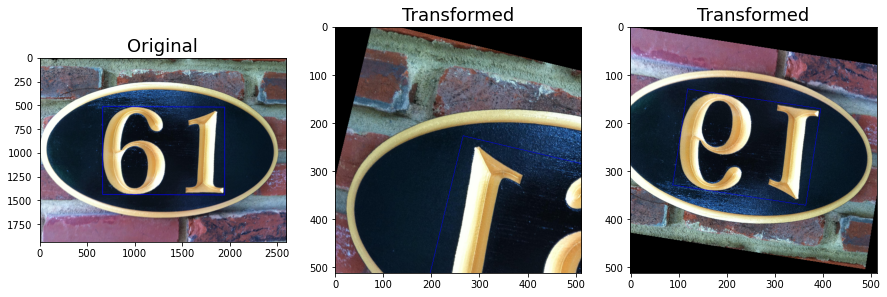

In [17]:
transform = ComposedTransformation(
    rotate_range=30, crop_aspect_ratio=1.0, crop_size=(0.5, 1.0),
    hflip=True, vflip=True, random_translate=True,
    resize_to=512,
)

transformed_1 = transform(image=image, word_bboxes=bboxes)
transformed_2 = transform(image=image, word_bboxes=bboxes)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1]))
vis = image.copy()
draw_bboxes(vis, bboxes, thickness=5)
axs[0].imshow(vis)
axs[0].set_title('Original', fontsize=18)
vis = transformed_1['image']
draw_bboxes(vis, transformed_1['word_bboxes'], thickness=1)
axs[1].imshow(vis)
axs[1].set_title('Transformed', fontsize=18)
vis = transformed_2['image']
draw_bboxes(vis, transformed_2['word_bboxes'], thickness=1)
axs[2].imshow(vis)
axs[2].set_title('Transformed', fontsize=18)

### 실행 속도 비교

Albumentations와 같은 라이브러리는 단일 함수의 실행 속도는 최적화가 잘 되어있지만, 여러 함수를 조합해서 이용하면 이미지에 대한 변환도 여러 번 수행되기 때문에 속도가 느려진다.

때문에 가급적 하나의 통합된 함수를 골라서 이용하는 것이 유리한데, 자유도의 면에서 불가피하게 여러 함수를 조합해야하는 경우도 있다.

- 예시 1: Rotate + Scale + Shear = Affine
- 예시 2: Affine + Random Crop & Resize = ? (단일 함수로 대체하기 어려운 경우)

이러한 경우 Albumentations 내부를 변형하거나 직접 새로 구현함으로써 더 효율적인 Augmentation 함수를 얻을 수 있다.

In [18]:
%timeit transform(image=image)

1.45 ms ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%timeit transform(image=image, word_bboxes=bboxes)

1.56 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Text(0.5, 1.0, 'Transformed')

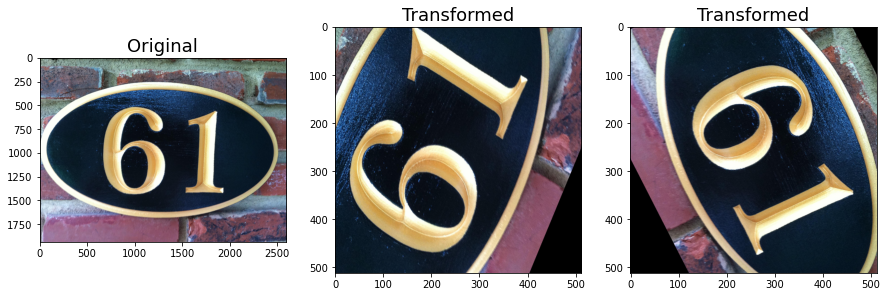

In [20]:
alb_transform = A.Compose([
    A.Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(), A.VerticalFlip(),
    A.RandomResizedCrop(p=1.0, height=512, width=512, scale=(0.5, 1.0))
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1]))
axs[0].imshow(image)
axs[0].set_title('Original', fontsize=18)
axs[1].imshow(alb_transform(image=image, bboxes=[])['image'])
axs[1].set_title('Transformed', fontsize=18)
axs[2].imshow(alb_transform(image=image, bboxes=[])['image'])
axs[2].set_title('Transformed', fontsize=18)

In [21]:
%timeit alb_transform(image=image, bboxes=[])

9.84 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit alb_transform(image=image, bboxes=bboxes_voc)

10.3 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Patch Sampling에 규칙을 적용해보자

이용하는 주요 인자들은 아래와 같다.
- min_image_overlap: Patch 영역 중 이미지의 유효 영역(외부가 아닌 영역)의 비율이 일정 수준 이상 되도록 제한
- min_bbox_overlap: Bounding Box가 Patch 내부에 어느 정도 이상 나타났을 때 "온전하다"고 판단할지 정의
- min_bbox_count: Patch에 온전하게 포함되어있는 Bounding Box가 몇 개 이상 존재하도록 제한
- allow_partial_occurrence: Bounding Box가 부분적으로 나타나는 것을 허용할지 정의
- max_random_trials: 위의 조건들을 만족하는 Patch를 몇 번까지 반복하며 탐색할지 정의

먼저 최소 1개의 개체를 온전하게 포함하고 잘리는 개체들이 없도록 규칙을 넣어본다.

Text(0.5, 1.0, 'Transformed (# Trials: 1000)')

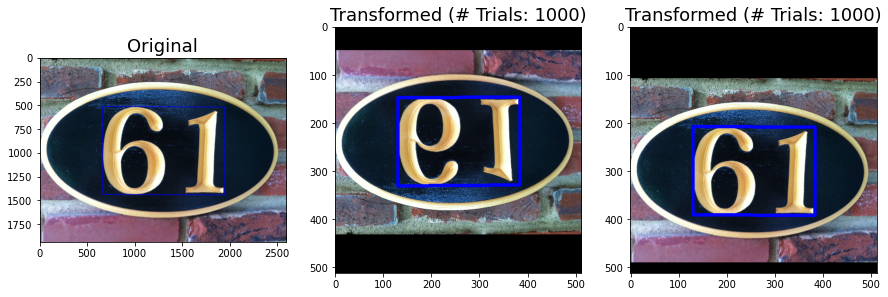

In [25]:
transform = ComposedTransformation(
    rotate_range=30, crop_aspect_ratio=1.0, crop_size=(0.2, 0.2),
    hflip=True, vflip=True, random_translate=True,
    resize_to=512,
    min_image_overlap=0.9, min_bbox_overlap=0.99, min_bbox_count=1, allow_partial_occurrence=False,
    max_random_trials=1000,
)

transformed_1 = transform(image=image, word_bboxes=bboxes)
transformed_2 = transform(image=image, word_bboxes=bboxes)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1]))
vis = image.copy()
draw_bboxes(vis, bboxes, thickness=5)
axs[0].imshow(vis)
axs[0].set_title('Original', fontsize=18)
vis = transformed_1['image']
draw_bboxes(vis, transformed_1['word_bboxes'], thickness=5)
axs[1].imshow(vis)
axs[1].set_title('Transformed (# Trials: {})'.format(transformed_1['num_trials']), fontsize=18)
vis = transformed_2['image']
draw_bboxes(vis, transformed_2['word_bboxes'], thickness=5)
axs[2].imshow(vis)
axs[2].set_title('Transformed (# Trials: {})'.format(transformed_2['num_trials']), fontsize=18)

위의 조건대로는 Random Patch Cropping이 쉽지 않다. (Bounding Box의 경계를 피해가며 Patch의 위치를 잡기가 쉽지 않기 때문)

조건을 완화해서, 최소 1개의 개체를 온전하게 포함하되 나머지 개체들이 잘리는 것은 허용하도록 해보자.

탐색 시도 횟수가 훨씬 줄어드는 것을 볼 수 있다.

이렇게 잘린 상태로 나타나는 개체들이 학습에 악영향을 주는 경우 Masking 처리를 해주는 방법이 있다.

Text(0.5, 1.0, 'Transformed (# Trials: 1000)')

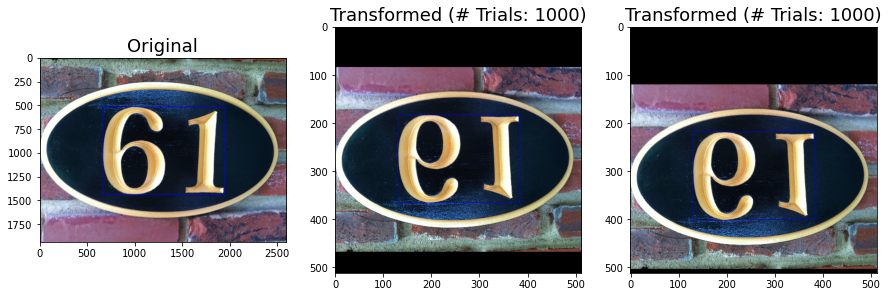

In [24]:
transform = ComposedTransformation(
    rotate_range=30, crop_aspect_ratio=1.0, crop_size=(0.2, 0.2),
    hflip=True, vflip=True, random_translate=True,
    resize_to=512,
    min_image_overlap=0.9, min_bbox_overlap=0.99, min_bbox_count=1, allow_partial_occurrence=True,
    max_random_trials=1000,
)

transformed_1 = transform(image=image, word_bboxes=bboxes)
transformed_2 = transform(image=image, word_bboxes=bboxes)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1]))
vis = image.copy()
draw_bboxes(vis, bboxes, thickness=5)
axs[0].imshow(vis)
axs[0].set_title('Original', fontsize=18)
vis = transformed_1['image']
draw_bboxes(vis, transformed_1['word_bboxes'], thickness=1)
axs[1].imshow(vis)
axs[1].set_title('Transformed (# Trials: {})'.format(transformed_1['num_trials']), fontsize=18)
vis = transformed_2['image']
draw_bboxes(vis, transformed_2['word_bboxes'], thickness=1)
axs[2].imshow(vis)
axs[2].set_title('Transformed (# Trials: {})'.format(transformed_2['num_trials']), fontsize=18)